In [113]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#auto
#plt.ioff()

##### TODO: select the strongest peaks only

peaks = np.load('cxitut13_peaks233.npy')
iX = np.load('cxitut13_iX.npy')
iY = np.load('cxitut13_iY.npy')

cx = 877 # self.parent.cx
cy = 864 # self.parent.cy

photonEnergy = 8.06 # keV
D = 0.158 # m
pixSize = 110e-6 # m
wavelength = 12.407002 / float(photonEnergy) * 1e-10  # m

cenX = iX[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels
cenY = iY[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels

#strongInd = np.where(cenX > 500) and np.where(cenX < 1100) and np.where(cenY > 500) and np.where(cenY < 1100)
#cenX = cenX[strongInd]
#cenY = cenY[strongInd]

Xd = (cenX - cx) * pixSize # m
Yd = (cenY - cy) * pixSize # m
r = np.sqrt(Xd**2 + Yd**2 + D**2) # m
s = np.array([D/r-1, Xd/r, Yd/r]) / (wavelength) # m^-1

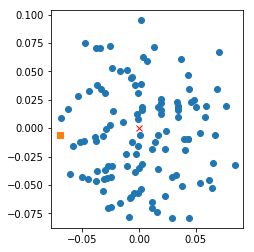

pixels:  -633.5 -56.5


In [114]:
plt.plot(Xd,Yd,'o')
plt.plot(Xd[108],Yd[108],'s')
plt.plot(0,0,'rx')
plt.axis('scaled')
plt.show()
print("pixels: ", Xd[108]/pixSize,Yd[108]/pixSize)

In [115]:
_,numPeaks = s.shape

#norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
#qPeaks = np.array([x,y,z])/(wavelength*norm)
#s = np.array([D/r-1, Xd/r, Yd/r]) # unitless        

print("s0: ",s[:,0], np.sqrt(np.sum(s[:,0]**2)))
#print(qPeaks)

import matplotlib.pyplot as plt
#plt.plot(y,x,'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#plt.plot(qPeaks[0,:],qPeaks[1,:],'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#from mpl_toolkits.mplot3d import Axes3D
#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#ax.scatter(*s)
#ax.set_aspect('equal')
#plt.show()

#ind = 5
#print(np.sqrt(qPeaks[0,ind]**2+qPeaks[1,ind]**2+(qPeaks[2,ind])**2))

s0:  [-3.57518748e+08 -1.70313205e+09  1.27147249e+09] 2155254214.2170777


In [116]:
import math, random

def fibonacci_sphere(samples=1,randomize=False):
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = np.zeros((samples,3))
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));
    print(offset, increment, increment*180/(2*3.14))

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment
        
        x = math.cos(phi) * r
        z = math.sin(phi) * r

        if z > 0:
            points[i,0] = -x
            points[i,1] = y
            points[i,2] = -z          
        else:
            points[i,0] = x
            points[i,1] = y
            points[i,2] = z

    return points

0.00013333333333333334 2.399963229728653 68.78875499222254


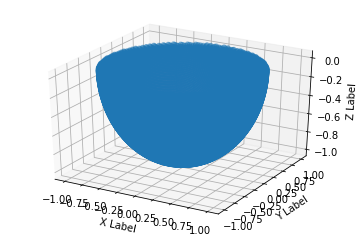

In [117]:
numSamples=15000
pts = fibonacci_sphere(samples=numSamples)
tx = pts[:,1]
ty = pts[:,2]
tz = pts[:,0]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#plt.axis('equal')
plt.show()

In [118]:
def fj(signal, nBins):
    maxSignal = np.max(signal)
    bins = np.linspace(0, maxSignal, nBins)
    binSize = maxSignal/nBins
    digitized = np.digitize(signal, bins)
    ff = np.zeros((nBins,))
    for i in digitized:
        ff[i-1] += 1
    return ff, bins, binSize

_f = np.zeros((numSamples,numPeaks))
numBins = 2800
f = np.zeros((numSamples,numBins))
F = np.zeros((numSamples,int(numBins/2)))
candidate = []
candidateVec = []
candidateLen = []
candidateLikely = []
threshF = 50
gap = 5
for j in range(numSamples):
    t = np.array([tx[j], ty[j], tz[j]])
    for i in range(numPeaks):
        q = s[:,i] # Bragg spots in reciprocal space
        p = np.abs(np.dot(q, t)) # Bragg spots projected on to vector t
        _f[j,i] = p 
    f[j,:],bins,binSize = fj(_f[j,:],numBins)   
    sp = np.fft.fftshift(abs(np.fft.fft(f[j,:])))
    F[j,:] = sp[int(numBins/2)::]
    if len(np.where(F[j,gap::]>threshF)[0]):
        candidate.append(j)
        print("candidate: ", j)
        candidateVec.append(t)
        print("t: ", t)
        #print("q: ", q)
        #print("p: ", p)
        #print("binSize: ", binSize)
        ii = np.where(F[j,gap::]>threshF)[0][0]
        print("pos: ", ii+gap)
        likely = F[j,ii+gap]
        print(likely)
        x_real = (ii+gap) / (numBins * binSize)
        print("unit cell basis vector (real-space dimension): ", x_real)
        candidateLen.append(x_real)
        candidateLikely.append(likely)
        fRange = (numBins * binSize) # m^-1
        FbinSize = 1/fRange # m
        Faxis = range(F.shape[1]) * FbinSize * 1e10 # Angstroms
        #plt.subplot(121)
        #plt.plot(bins,f[j,:])
        #plt.subplot(122)
        #plt.plot(Faxis,F[j,:])
        #plt.xlabel('Axis length (A)')
        #plt.xticks(np.array([0,50,100,150,200]))
        #plt.show()
        #break
print(candidate)

candidate:  2365
t:  [-0.6846     -0.72404389 -0.08416224]
pos:  20
64.68259596734262
unit cell basis vector (real-space dimension):  8.705635557570933e-09
candidate:  2437
t:  [-0.675      -0.73367942 -0.07803533]
pos:  20
60.97318128667704
unit cell basis vector (real-space dimension):  8.636197652650923e-09
candidate:  3266
t:  [-0.56446667 -0.55378     0.6121316 ]
pos:  71
52.37479194289286
unit cell basis vector (real-space dimension):  2.329873363896917e-08
candidate:  4230
t:  [-0.43593333 -0.52069659 -0.73405531]
pos:  32
61.00872901477751
unit cell basis vector (real-space dimension):  1.1761412955827226e-08
candidate:  4382
t:  [-0.41566667 -0.75869462 -0.50160114]
pos:  49
56.055189500856805
unit cell basis vector (real-space dimension):  1.7983233775170147e-08
candidate:  5148
t:  [-0.31353333 -0.94865677 -0.04179924]
pos:  21
57.7688372344344
unit cell basis vector (real-space dimension):  7.86665714741738e-09
candidate:  5381
t:  [-0.28246667 -0.95776837 -0.05378036]
pos:

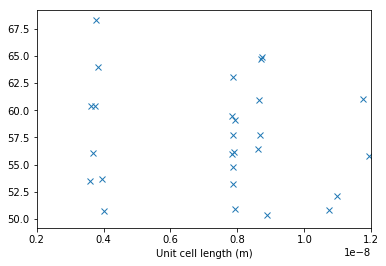

In [7]:
plt.plot(candidateLen,candidateLikely,'x')
plt.xlim([20e-10,120e-10])
plt.xlabel('Unit cell length (m)')
plt.show()

In [8]:
for ind in range(len(candidateLen)):
    print(ind,candidateVec[ind],candidateLikely[ind],candidateLen[ind])

0 [-0.6846     -0.72404389 -0.08416224] 64.68259596734262 8.705635557570933e-09
1 [-0.675      -0.73367942 -0.07803533] 60.97318128667704 8.636197652650923e-09
2 [-0.56446667 -0.55378     0.6121316 ] 52.37479194289286 2.329873363896917e-08
3 [-0.43593333 -0.52069659 -0.73405531] 61.00872901477751 1.1761412955827226e-08
4 [-0.41566667 -0.75869462 -0.50160114] 56.055189500856805 1.7983233775170147e-08
5 [-0.31353333 -0.94865677 -0.04179924] 57.7688372344344 7.86665714741738e-09
6 [-0.28246667 -0.95776837 -0.05378036] 59.432176074868 7.839087248026177e-09
7 [-0.27286667 -0.96101926 -0.04456192] 56.0201305937494 7.836096116356496e-09
8 [-0.2286     -0.33173058 -0.91525781] 51.52400289124435 1.7984073192373793e-08
9 [-0.22646667 -0.84392449 -0.48631708] 50.585106570962836 1.7631277137915234e-08
10 [-0.1594     -0.94679327  0.2795964 ] 55.971535012264056 2.5052020011811863e-08
11 [-0.12686667 -0.0286173   0.99150688] 54.75383039911612 7.861563951036557e-09
12 [-0.11726667 -0.0189649   0.9929

In [119]:
mostLikelyInd = np.argsort(candidateLikely)[::-1]

In [120]:
shortListVec = []
shortListLen = []
for i,val in enumerate(mostLikelyInd):
    duplicate = False
    _len = candidateLen[val]
    _vec = candidateVec[val]
    if i == 0: 
        shortListLen.append(_len)
        shortListVec.append(_vec)
    else:
        for j,val2 in enumerate(shortListLen):
            if np.abs(_len-val2) < 1e-9 and np.dot(_vec,shortListVec[j]) > 0.95:
                duplicate = True
        if not duplicate:
            shortListLen.append(_len)
            shortListVec.append(_vec)

In [11]:
shortListLen, shortListVec

([3.785292028901448e-09,
  8.734479992931272e-09,
  8.705635557570933e-09,
  7.86966577790195e-09,
  1.1761412955827226e-08,
  7.839087248026177e-09,
  1.3491696359609542e-08,
  8.675023094110526e-09,
  1.7983233775170147e-08,
  2.5052020011811863e-08,
  1.192172518081708e-08,
  1.75101574189405e-08,
  2.329873363896917e-08,
  1.9177173262398286e-08,
  1.0964881092657218e-08,
  1.7984073192373793e-08,
  1.0733902775881479e-08,
  8.893968681138614e-09,
  1.6230800983785425e-08],
 [array([ 0.94593333, -0.31208094,  0.08840597]),
  array([ 0.15073333, -0.98853853, -0.00842814]),
  array([-0.6846    , -0.72404389, -0.08416224]),
  array([-0.11726667, -0.0189649 ,  0.99291936]),
  array([-0.43593333, -0.52069659, -0.73405531]),
  array([-0.28246667, -0.95776837, -0.05378036]),
  array([ 0.40953333, -0.71969696, -0.56064136]),
  array([ 0.50286667, -0.11306701, -0.85693697]),
  array([-0.41566667, -0.75869462, -0.50160114]),
  array([-0.1594    , -0.94679327,  0.2795964 ]),
  array([ 0.19153

In [121]:
# Manually selected vectors 0, 3, and 5
a = shortListVec[0]*shortListLen[0]
b = shortListVec[3]*shortListLen[3]
c = shortListVec[5]*shortListLen[5]
print(a)
print(b)
print(c)

[ 3.58063391e-09 -1.18131750e-09  3.34642398e-10]
[-9.22849474e-10 -1.49247462e-10  7.81394353e-09]
[-2.21428084e-09 -7.50802983e-09 -4.21588933e-10]


In [122]:
print(np.arccos(np.dot(shortListVec[0],shortListVec[3])) * 180/(np.pi))
print(np.arccos(np.dot(shortListVec[5],shortListVec[0])) * 180/(np.pi))
print(np.arccos(np.dot(shortListVec[5],shortListVec[3])) * 180/(np.pi))

90.98713296689284
88.4555705292793
90.1209887403909


In [123]:
A = np.matrix([b,c,a]) # m
print(A)

from numpy.linalg import inv
Ainv = inv(A) # m^-1
print(Ainv)
astar = Ainv[:,0]
bstar = Ainv[:,1]
cstar = Ainv[:,2]
print("a*: ", astar)

[[-9.22849474e-10 -1.49247462e-10  7.81394353e-09]
 [-2.21428084e-09 -7.50802983e-09 -4.21588933e-10]
 [ 3.58063391e-09 -1.18131750e-09  3.34642398e-10]]
[[-1.28986845e+07 -3.93352913e+07  2.51630604e+08]
 [-3.29292132e+06 -1.21199057e+08 -7.57987629e+07]
 [ 1.26390086e+08 -6.96053206e+06  2.82705393e+07]]
a*:  [[-1.28986845e+07]
 [-3.29292132e+06]
 [ 1.26390086e+08]]


In [125]:
print(A)
print(s[:,108]) # reciprocal orthonormal basis
f = np.dot(A,s[:,108])
h = np.round(f)
#f = A * s[:,108] # reciprocal unit cell basis vectors
print("h,k,l: ", h)

[[-9.22849474e-10 -1.49247462e-10  7.81394353e-09]
 [-2.21428084e-09 -7.50802983e-09 -4.21588933e-10]
 [ 3.58063391e-09 -1.18131750e-09  3.34642398e-10]]
[-5.56277970e+08 -2.61982685e+09 -2.33654644e+08]
h,k,l:  [[-1. 21.  1.]]


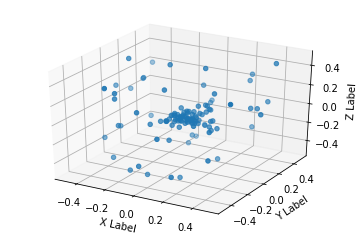

In [126]:
residue = np.zeros((numPeaks,3))
miller = np.zeros_like(residue)
for i in range(numPeaks):
    f = np.dot(A,s[:,i])
    h = np.round(f)
    residue[i,:] = f-h
    miller[i,:] = h
#print(residue)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(residue[:,0],residue[:,1],residue[:,2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#plt.axis('equal')
plt.show()

# Detection and correction of a non-primitive basis

In [127]:
# Step 1
G0 = []
mag = []
for i in np.arange(-5,5):
    for j in np.arange(-5,5):
        for k in np.arange(-5,5):
            if i == 0 and j == 0 and k == 0:
                continue
            G0.append([i,j,k])
            mag.append(np.linalg.norm([i,j,k]))
sortInd = np.argsort(mag)
G0sort = []
for i in sortInd:
    G0sort.append(G0[i])

def hasCollinear(a,b):
    """Compare list of vectors a with vector b to see if collinear"""
    collinear = False
    for i in a:
        if np.sum(np.abs(np.cross(i,b))) == 0:
            collinear = True
            break
    return collinear

def isCoplanar(a,b,c):
    """Check whether vector c is coplanar with plane formed by vectors a & b"""
    coplanar = True if np.dot(c, np.cross(a,b))==0 else False
    return coplanar

G1 = []
for i, g in enumerate(G0sort):
    if np.dot(g,g) <= 6 and not hasCollinear(G1,g):
        G1.append(g)
print(G1)
print("Combinations: ", len(G1))

[[0, 0, 1], [-1, 0, 0], [0, 1, 0], [0, 1, -1], [-1, 0, -1], [0, -1, -1], [1, -1, 0], [-1, -1, 0], [1, 0, -1], [-1, 1, -1], [1, 1, 1], [-1, -1, 1], [1, -1, -1], [-1, 2, 0], [0, -1, 2], [-2, 1, 0], [0, -1, -2], [0, -2, 1], [-1, 0, 2], [0, -2, -1], [-1, -2, 0], [-1, 0, -2], [2, 0, -1], [2, 0, 1], [-2, -1, 0], [2, 1, 1], [2, 1, -1], [-1, -2, 1], [-1, -1, -2], [-2, 1, -1], [2, -1, -1], [-1, -2, -1], [-1, 1, -2], [-1, 1, 2], [-1, 2, -1], [-1, 2, 1], [-1, -1, 2]]
Combinations:  37


In [129]:
def generateTransform(g,M):
    T = np.zeros((3,3))
    found = 0
    for ga in G0sort:
        dotprod = np.dot(g,ga)
        if found == 0:
            if dotprod%M==0:
                T[found,:] = ga
                found += 1
        elif found == 1:
            if dotprod%M==0 and not hasCollinear([T[0,:]],ga):
                T[found,:] = ga
                found += 1
        elif found == 2:
            if dotprod%M==0 and not isCoplanar(T[0,:],T[1,:],ga):
                T[found,:] = ga
                found += 1
    if found < 3:
        return None
    if np.linalg.det(T) < 0:
        T1 = np.array([T[1,:],T[0,:],T[2,:]])
        return T1
    else:
        return T

In [140]:
print(astar)
print(Ainv)
print(np.transpose(Ainv))

[[-1.28986845e+07]
 [-3.29292132e+06]
 [ 1.26390086e+08]]
[[-1.28986845e+07 -3.93352913e+07  2.51630604e+08]
 [-3.29292132e+06 -1.21199057e+08 -7.57987629e+07]
 [ 1.26390086e+08 -6.96053206e+06  2.82705393e+07]]
[[-1.28986845e+07 -3.29292132e+06  1.26390086e+08]
 [-3.93352913e+07 -1.21199057e+08 -6.96053206e+06]
 [ 2.51630604e+08 -7.57987629e+07  2.82705393e+07]]


In [170]:
for g in G1:
    for m in [2,3,5]:
        myT = generateTransform(g,m)
        if myT is not None:
            B = myT*np.transpose(Ainv)
            Anew = inv(B)
            satisfied = 0
            for i in range(numPeaks):
                fnew = np.dot(Anew,s[:,i])
                hnew = np.round(fnew)
                _t = np.dot(hnew,g)
                if _t%m==0:
                    satisfied += 1
            if satisfied/numPeaks > 0.5:
                print(satisfied/numPeaks, g, m)
                print(myT)

0.5217391304347826 [0, 0, 1] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5304347826086957 [-1, 0, 0] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5217391304347826 [0, 1, 0] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5565217391304348 [1, -1, 0] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5565217391304348 [-1, -1, 0] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5130434782608696 [-1, 1, -1] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5130434782608696 [1, 1, 1] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5130434782608696 [-1, -1, 1] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5130434782608696 [1, -1, -1] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5304347826086957 [-1, 2, 0] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5217391304347826 [0, -1, 2] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5217391304347826 [-2, 1, 0] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5217391304347826 [0, -1, -2] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5217391304347826 [0, -2, 1] 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.5304347826086957 [-1, 0, 2] 2


In [173]:
# Checkpoint1: Volume test
_a = shortListVec[0]*shortListLen[0]
_b = shortListVec[3]*shortListLen[3]
_c = shortListVec[5]*shortListLen[5]
V = np.dot(np.cross(_a,_b),_c) 
print(V)
_t = shortListLen[0]*shortListLen[3]*shortListLen[5]/100
print(_t)
print(V > _t) # True means pass

2.3339864556380823e-25
2.3351843785825393e-27
True


In [ ]:
# Checkpoint2: rmsd test between f and h

In [ ]:
# Checkpoint3: 

In [ ]:
# Checkpoint4: rmsd test between x and h

In [ ]:
# Checkpoint5: fraction of predicted vs observed